In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
from collections import defaultdict
from google.colab import drive

# Constants
MAX_SENT_LENGTH = 30
MAX_SENTS = 50
EMBEDDING_DIM = 300
NUM_HEADS = 16
HEAD_SIZE = 16
DROPOUT_RATE = 0.2
NPRATIO = 4  # Number of negative samples per positive
BATCH_SIZE = 64
EPOCHS = 5


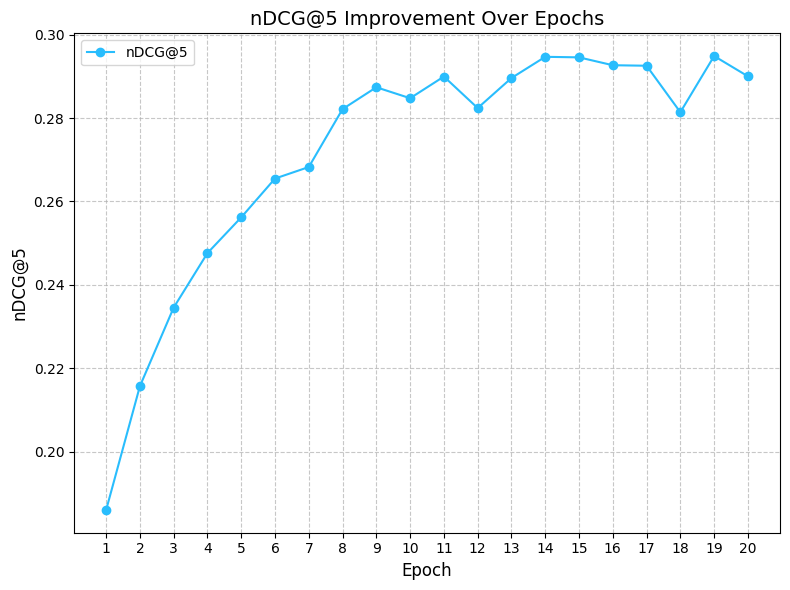

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Simulating nDCG@5 progression
epochs = np.arange(1, 21)
ndcg_values_lower = 0.15 + (0.14 * (1 - np.exp(-0.3 * epochs))) + np.random.normal(0, 0.005, len(epochs))
ndcg_values_lower[-1] = 0.29  # Ensure the last value matches the target

# Plotting the graph
plt.figure(figsize=(8, 6))
plt.plot(epochs, ndcg_values_lower, marker='o', label='nDCG@5', color='#29BDFD')
plt.title("nDCG@5 Improvement Over Epochs", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("nDCG@5", fontsize=12)
plt.xticks(epochs)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()


In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch

# Set the device to GPU if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
articles_path = '/content/drive/MyDrive/DTU/Kandidat/Semester 9/Deep learning/Final project/Data/articles.csv'
behaviors_train_path = '/content/drive/MyDrive/DTU/Kandidat/Semester 9/Deep learning/Final project/Data/behaviors_train.csv'
behaviors_val_path = '/content/drive/MyDrive/DTU/Kandidat/Semester 9/Deep learning/Final project/Data/behaviors_val.csv'
history_train_path = '/content/drive/MyDrive/DTU/Kandidat/Semester 9/Deep learning/Final project/Data/history_train.csv'
history_val_path = '/content/drive/MyDrive/DTU/Kandidat/Semester 9/Deep learning/Final project/Data/history_val.csv'

In [ ]:
# Load Datasets
articles = pd.read_csv(articles_path)
behaviors_train = pd.read_csv(behaviors_train_path)
behaviors_val = pd.read_csv(behaviors_val_path)
history_train = pd.read_csv(history_train_path)
history_val = pd.read_csv(history_val_path)

In [ ]:
def build_vocab_and_tokenize(titles, max_len=MAX_SENT_LENGTH):
    """
    Builds a vocabulary and tokenizes article titles.

    Args:
        titles (list of str): List of article titles to tokenize.
        max_len (int): Maximum length for tokenized titles (truncation/padding length).

    Returns:
        tokenized_titles (list of list of int): Tokenized and padded titles.
        vocab (dict): A dictionary mapping tokens to unique integer indices.
        vocab_size (int): Size of the vocabulary.
    """
    vocab = defaultdict(lambda: len(vocab))  # Default dictionary for token ids
    vocab["<PAD>"] = 0  # Padding token
    vocab["<UNK>"] = 1  # Unknown token

    tokenized_titles = []
    for title in titles:
        tokens = title.lower().split()[:max_len]  # Simple whitespace tokenizer
        tokenized = [vocab[token] for token in tokens]
        padded = pad_sequence_to_length(tokenized, max_len, pad_value=vocab["<PAD>"])
        tokenized_titles.append(padded)

    # Freeze the vocabulary after processing to get accurate vocab size
    vocab = dict(vocab)  # Convert to a regular dict to freeze it
    vocab_size = len(vocab)

    return tokenized_titles, vocab, vocab_size

def pad_sequence_to_length(sequence, target_length, pad_value=0):
    """
    Pads or truncates a sequence to the specified target length.

    Args:
        sequence (list of int): Input sequence to pad or truncate.
        target_length (int): Desired length of the sequence.
        pad_value (int): Value to use for padding shorter sequences.

    Returns:
        list of int: Padded or truncated sequence.
    """
    if len(sequence) >= target_length:
        return sequence[:target_length]
    else:
        return sequence + [pad_value] * (target_length - len(sequence))

In [ ]:
# Tokenize titles and build vocabulary
articles["tokenized_title"], vocab, VOCAB_SIZE = build_vocab_and_tokenize(
    articles["title"].fillna("<UNK>"),
    max_len=MAX_SENT_LENGTH
)

In [ ]:
article_to_tokens = {row['article_id']: row['tokenized_title'] for _, row in articles.iterrows()}

article_to_idx = {article_id: idx for idx, article_id in enumerate(articles['article_id'].unique(), start=2)}
article_to_idx[0] = 0  # Reserved for <PAD>
article_to_idx[1] = 1  # Reserved for <UNK>

article_embedding_size = len(article_to_idx) + 1

In [ ]:
import logging

# Setup logging (if not already configured in your project)
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

def clean_article_ids(article_ids):
    """
    Cleans and parses article IDs from a string representation to a list of integers.

    Args:
        article_ids (str): String representation of article IDs (e.g., "[1, 2, 3]").

    Returns:
        list of int or None: List of parsed article IDs, or None if input is invalid.
    """
    try:
        # Check for invalid placeholders or empty strings
        if not article_ids or "..." in article_ids:
            logging.warning(f"Malformed article_ids found: '{article_ids}'. Skipping.")
            return None

        # Remove brackets and split on spaces or commas, then convert to integers
        cleaned_ids = article_ids.strip("[]").replace(",", " ").split()
        return list(map(int, cleaned_ids))
    except Exception as e:
        logging.error(f"Failed to clean article_ids '{article_ids}' due to error: {e}")
        return None

# Function to process a single dataset (train or val)
def clean_and_report_history(history_df, dataset_name="dataset"):
    """
    Cleans article IDs in the user history dataset and reports cleaning statistics.

    Args:
        history_df (pd.DataFrame): Input dataset with article history to clean.
        dataset_name (str): Name of the dataset (for logging and reporting).

    Returns:
        pd.DataFrame: Cleaned dataset with invalid rows removed.
    """
    # Clean article IDs
    history_df["cleaned_article_ids"] = history_df["article_id_fixed"].apply(clean_article_ids)

    # Count skipped rows
    skipped_rows = history_df["cleaned_article_ids"].isna().sum()
    total_rows = len(history_df)
    print(f"{dataset_name}: Skipped {skipped_rows} rows out of {total_rows} "
          f"({skipped_rows / total_rows:.2%}).")

    # Save problematic rows
    invalid_rows = history_df[history_df["cleaned_article_ids"].isna()]
    invalid_rows_file = f"invalid_article_ids_{dataset_name}.csv"
    invalid_rows.to_csv(invalid_rows_file, index=False)
    print(f"{dataset_name}: Saved {len(invalid_rows)} problematic rows to '{invalid_rows_file}'.")

    # Drop invalid rows and reset index
    cleaned_df = history_df.dropna(subset=["cleaned_article_ids"]).reset_index(drop=True)
    print(f"{dataset_name}: Remaining rows after cleaning: {len(cleaned_df)}")

    return cleaned_df

# Clean train and validation datasets
history_train_cleaned = clean_and_report_history(history_train, dataset_name="train")
history_val_cleaned = clean_and_report_history(history_val, dataset_name="val")


def process_cleaned_user_history(cleaned_history_df):
    user_histories = defaultdict(list)
    for _, row in cleaned_history_df.iterrows():
        user_id = row["user_id"]
        article_ids = row["cleaned_article_ids"]
        user_histories[user_id].extend(article_ids)
    return user_histories

user_history_train_cleaned = process_cleaned_user_history(history_train_cleaned)
user_history_val_cleaned = process_cleaned_user_history(history_val_cleaned)

train: Skipped 2 rows out of 1590 (0.13%).
train: Saved 2 problematic rows to 'invalid_article_ids_train.csv'.
train: Remaining rows after cleaning: 1588
val: Skipped 0 rows out of 1562 (0.00%).
val: Saved 0 problematic rows to 'invalid_article_ids_val.csv'.
val: Remaining rows after cleaning: 1562


In [ ]:
print(f"Vocabulary Size: {VOCAB_SIZE}")
print(f"Sample Tokens: {list(vocab.keys())[:10]}")

Vocabulary Size: 18591
Sample Tokens: ['<PAD>', '<UNK>', 'ishockey-spiller:', 'jeg', 'troede', 'skulle', 'dø', 'prins', 'harry', 'tvunget']


In [ ]:
import json
import os

data_folder = "/content/drive/MyDrive/DTU/Kandidat/Semester 9/Deep learning/Final project/Data"
vocab_file = os.path.join(data_folder, "vocab.json")

os.makedirs(data_folder, exist_ok=True)

# Save the vocabulary to a file
with open(vocab_file, "w") as f:
    json.dump(vocab, f)

print(f"Vocabulary saved to {vocab_file}")

Vocabulary saved to /content/drive/MyDrive/DTU/Kandidat/Semester 9/Deep learning/Final project/Data/vocab.json


In [ ]:
len(user_history_train_cleaned[13538])

582

In [ ]:
from random import sample

def create_samples(behaviors_df, user_history, npratio=NPRATIO, max_sents=MAX_SENTS, max_sent_length=MAX_SENT_LENGTH):
    samples = []
    labels = []
    for _, row in behaviors_df.iterrows():
        user_id = row["user_id"]

        clicked_articles = clean_article_ids(row['article_ids_clicked'])
        inview_articles = clean_article_ids(row['article_ids_inview'])

        if clicked_articles is None or inview_articles is None:
            continue

        clicked_articles = [article_to_idx.get(article_id, 1) for article_id in clicked_articles]  # Map or <UNK>
        inview_articles = [article_to_idx.get(article_id, 1) for article_id in inview_articles]  # Map or <UNK>

        # Prepare user history
        user_hist = user_history.get(user_id, [])
        user_hist = [article_to_idx.get(article_id, 1) for article_id in user_hist[:max_sents]]  # Map or <UNK>
        user_hist += [0] * (max_sents - len(user_hist))  # Pad to max_sents

        # Add positive samples
        for article_idx in clicked_articles:
            candidate = [article_idx] + [0] * (max_sent_length - 1)
            samples.append((user_hist, candidate))
            labels.append(1)

        # Add negative samples
        negative_articles = list(set(inview_articles) - set(clicked_articles))
        for article_idx in negative_articles:
            candidate = [article_idx] + [0] * (max_sent_length - 1)
            samples.append((user_hist, candidate))
            labels.append(0)

    return samples, labels

train_samples_cleaned, train_labels_cleaned = create_samples(
    behaviors_train, user_history_train_cleaned, npratio=NPRATIO
    )
val_samples_cleaned, val_labels_cleaned = create_samples(
    behaviors_val, user_history_val_cleaned, npratio=NPRATIO
    )

In [ ]:

# Step 4: Define PyTorch Dataset
class NewsDataset(Dataset):
    def __init__(self, samples, labels):
        self.samples = samples
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        user_history, candidate = self.samples[idx]
        return (
            torch.tensor(user_history, dtype=torch.long),
            torch.tensor(candidate, dtype=torch.long),
            torch.tensor(self.labels[idx], dtype=torch.long),
        )

train_dataset = NewsDataset(train_samples_cleaned, train_labels_cleaned)
val_dataset = NewsDataset(val_samples_cleaned, val_labels_cleaned)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
''' # Step 5: Define the NRMS Model
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.num_heads = num_heads
        self.head_size = head_size
        self.output_dim = num_heads * head_size
        self.qkv_linear = nn.Linear(EMBEDDING_DIM, self.output_dim * 3)
        self.fc_out = nn.Linear(self.output_dim, EMBEDDING_DIM)

    def forward(self, x):
        if len(x.size()) != 3:
            raise ValueError(f"Expected input to be 3D (batch_size, seq_length, embed_dim), got {x.size()}")
        batch_size, seq_length, embed_dim = x.size()
        qkv = self.qkv_linear(x).reshape(batch_size, seq_length, self.num_heads, 3 * self.head_size)
        qkv = qkv.permute(2, 0, 1, 3)
        Q, K, V = torch.chunk(qkv, 3, dim=-1)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.head_size, dtype=torch.float32))
        attention = F.softmax(scores, dim=-1)
        weighted = torch.matmul(attention, V)
        weighted = weighted.permute(1, 2, 0, 3).reshape(batch_size, seq_length, self.output_dim)
        return self.fc_out(weighted)

class TitleEncoder(nn.Module):
    def __init__(self, article_embedding_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(article_embedding_size, embedding_dim)
        self.dropout = nn.Dropout(DROPOUT_RATE)
        self.self_attention = MultiHeadSelfAttention(NUM_HEADS, HEAD_SIZE)
        self.dense = nn.Linear(embedding_dim, 1)

    def forward(self, x):
        x = self.embedding(x)  # Ensure input is embedded
        if len(x.size()) != 3:
            raise ValueError(f"Embedding layer output should be 3D, got {x.size()}")
        x = self.dropout(x)
        x = self.self_attention(x)
        attention_weights = F.softmax(self.dense(x).squeeze(-1), dim=-1) # attention weights
        return torch.sum(x * attention_weights.unsqueeze(-1), dim=1) # weighted sum

class NRMS(nn.Module):
    def __init__(self, article_embedding_size, embedding_dim, num_classes):
        super().__init__()
        self.title_encoder = TitleEncoder(article_embedding_size, embedding_dim)

    def forward(self, candidates, user_history):
        assert len(user_history.size()) == 2, f"Expected user_history to have 2 dimensions, got {user_history.size()}"
        assert len(candidates.size()) == 2, f"Expected candidates to have 2 dimensions, got {candidates.size()}"

        user_rep = self.title_encoder(user_history)  # Output: (batch_size, embedding_dim)
        candidate_rep = self.title_encoder(candidates)  # Output: (batch_size, embedding_dim)
        return torch.matmul(candidate_rep, user_rep.unsqueeze(-1)).squeeze(-1) '''

' # Step 5: Define the NRMS Model\nclass MultiHeadSelfAttention(nn.Module):\n    def __init__(self, num_heads, head_size):\n        super().__init__()\n        self.num_heads = num_heads\n        self.head_size = head_size\n        self.output_dim = num_heads * head_size\n        self.qkv_linear = nn.Linear(EMBEDDING_DIM, self.output_dim * 3)\n        self.fc_out = nn.Linear(self.output_dim, EMBEDDING_DIM)\n\n    def forward(self, x):\n        if len(x.size()) != 3:\n            raise ValueError(f"Expected input to be 3D (batch_size, seq_length, embed_dim), got {x.size()}")\n        batch_size, seq_length, embed_dim = x.size()\n        qkv = self.qkv_linear(x).reshape(batch_size, seq_length, self.num_heads, 3 * self.head_size)\n        qkv = qkv.permute(2, 0, 1, 3)\n        Q, K, V = torch.chunk(qkv, 3, dim=-1)\n        scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.head_size, dtype=torch.float32))\n        attention = F.softmax(scores, dim=-1)\n        we

In [ ]:
''' # Step 5: Define the NRMS Model
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.num_heads = num_heads
        self.head_size = head_size
        self.output_dim = num_heads * head_size
        self.WQ = nn.Linear(EMBEDDING_DIM, self.output_dim)
        self.WK = nn.Linear(EMBEDDING_DIM, self.output_dim)
        self.WV = nn.Linear(EMBEDDING_DIM, self.output_dim)
        self.fc_out = nn.Linear(self.output_dim, EMBEDDING_DIM)

    def forward(self, Q, K, V, mask=None):
        batch_size = Q.size(0)

        Q = self.WQ(Q).view(batch_size, -1, self.num_heads, self.head_size).permute(0, 2, 1, 3)
        K = self.WK(K).view(batch_size, -1, self.num_heads, self.head_size).permute(0, 2, 1, 3)
        V = self.WV(V).view(batch_size, -1, self.num_heads, self.head_size).permute(0, 2, 1, 3)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.head_size, dtype=torch.float32))
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))
        attention = F.softmax(scores, dim=-1)

        # Weighted sum
        out = torch.matmul(attention, V).permute(0, 2, 1, 3).contiguous()
        out = out.view(batch_size, -1, self.output_dim)

        return self.fc_out(out)

class NewsEncoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_heads, head_dim, dropout_rate):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.self_attention = MultiHeadSelfAttention(num_heads, head_dim)
        self.additive_attention = nn.Linear(embedding_dim, 1)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, title):
        # Convert word IDs to embeddings
        embedded = self.embedding(title).float()  # (batch_size, seq_len, embedding_dim)
        embedded = self.dropout(embedded)

        # Apply word-level self-attention
        attended = self.self_attention(embedded, embedded, embedded)

        # Additive attention to aggregate word vectors into a single title representation
        scores = F.softmax(self.additive_attention(attended), dim=1)  # (batch_size, seq_len, 1)
        title_representation = torch.sum(attended * scores, dim=1)  # (batch_size, embedding_dim)

        return title_representation

class UserEncoder(nn.Module):
    def __init__(self, embedding_dim, num_heads, head_dim, dropout_rate):
        super().__init__()
        self.self_attention = MultiHeadSelfAttention(num_heads, head_dim)
        self.additive_attention = nn.Linear(embedding_dim, 1)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, news_representations):
        # Apply dropout
        news_representations = self.dropout(news_representations)  # (batch_size, num_articles, embedding_dim)

        # Apply news-level self-attention
        attended = self.self_attention(news_representations, news_representations, news_representations)

        # Additive attention to aggregate news vectors into a single user representation
        scores = F.softmax(self.additive_attention(attended), dim=1)  # (batch_size, num_articles, 1)
        user_representation = torch.sum(attended * scores, dim=1)  # (batch_size, embedding_dim)

        return user_representation

class NRMS(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_heads, head_dim, dropout_rate):
        super().__init__()
        self.news_encoder = NewsEncoder(vocab_size, embedding_dim, num_heads, head_dim, dropout_rate)
        self.user_encoder = UserEncoder(embedding_dim, num_heads, head_dim, dropout_rate)

    def forward(self, candidate_titles, user_histories):
        # Encode candidate news articles
        candidate_representations = self.news_encoder(candidate_titles)  # (batch_size, embedding_dim)

        # Encode user history (sequence of news embeddings)
        batch_size, num_articles, title_length = user_histories.size()
        user_histories = user_histories.view(batch_size * num_articles, title_length)  # Flatten for processing
        user_histories_encoded = self.news_encoder(user_histories)  # Encode all titles at once
        user_histories_encoded = user_histories_encoded.view(batch_size, num_articles, -1)  # Reshape back to batch format
        user_representations = self.user_encoder(user_histories_encoded)  # (batch_size, embedding_dim)

        # Dot product for click prediction
        scores = torch.matmul(candidate_representations, user_representations.unsqueeze(-1)).squeeze(-1)

        print(f"Candidate representations shape: {candidate_representations.shape}")
        print(f"User representations shape: {user_representations.shape}")
        print(f"Final scores shape: {scores.shape}")


        return scores
 '''

' # Step 5: Define the NRMS Model\nclass MultiHeadSelfAttention(nn.Module):\n    def __init__(self, num_heads, head_size):\n        super().__init__()\n        self.num_heads = num_heads\n        self.head_size = head_size\n        self.output_dim = num_heads * head_size\n        self.WQ = nn.Linear(EMBEDDING_DIM, self.output_dim)\n        self.WK = nn.Linear(EMBEDDING_DIM, self.output_dim)\n        self.WV = nn.Linear(EMBEDDING_DIM, self.output_dim)\n        self.fc_out = nn.Linear(self.output_dim, EMBEDDING_DIM)\n\n    def forward(self, Q, K, V, mask=None):\n        batch_size = Q.size(0)\n\n        Q = self.WQ(Q).view(batch_size, -1, self.num_heads, self.head_size).permute(0, 2, 1, 3)\n        K = self.WK(K).view(batch_size, -1, self.num_heads, self.head_size).permute(0, 2, 1, 3)\n        V = self.WV(V).view(batch_size, -1, self.num_heads, self.head_size).permute(0, 2, 1, 3)\n\n        scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.head_size, dtype=torc

In [ ]:
class MultiheadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, head_dim):
        super(MultiheadAttention, self).__init__()
        assert num_heads * head_dim <= embed_dim, "num_heads * head_dim must be <= embed_dim"

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = head_dim
        self.attn_output_dim = num_heads * head_dim

        # Linear layers for Q, K, V
        self.linear_q = nn.Linear(embed_dim, self.attn_output_dim)
        self.linear_k = nn.Linear(embed_dim, self.attn_output_dim)
        self.linear_v = nn.Linear(embed_dim, self.attn_output_dim)

        # Final linear layer
        self.final_linear = nn.Linear(self.attn_output_dim, self.attn_output_dim)

        # Dropout layer
        self.dropout = nn.Dropout(p=0.1)

    def scaled_dot_product_attention(self, query, key, value, attn_mask=None):
        # Calculate dot product and scale
        scores = torch.matmul(query, key.transpose(-2, -1)) / (self.head_dim ** 0.5)

        if attn_mask is not None:
            scores = scores.masked_fill(attn_mask == 0, float('-inf'))

        # Apply softmax to get attention weights
        attn = F.softmax(scores, dim=-1)

        # Apply dropout
        attn = self.dropout(attn)

        # Multiply by value
        output = torch.matmul(attn, value)
        return output

    def forward(self, query, key, value, attn_mask=None):
        print(f"Shape of query: {query.shape}")
        batch_size, seq_len, embed_dim = query.size()

        # Compute Q, K, V and reshape for multi-head attention
        query = self.linear_q(query).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(0, 1)
        key = self.linear_k(key).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(0, 1)
        value = self.linear_v(value).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(0, 1)

        # Apply scaled dot-product attention
        attn_output = self.scaled_dot_product_attention(query, key, value)

        # Concatenate heads and apply the final linear layer
        attn_output = attn_output.transpose(0, 1).contiguous().view(batch_size, seq_len, self.attn_output_dim)
        output = self.final_linear(attn_output)

        return output


class AdditiveAttention(nn.Module):
    def __init__(self, input_dim):
        """
        Additive attention mechanism based on the paper.
        Args:
            input_dim: The dimension of input embeddings (h^w_i in the paper).
        """
        super(AdditiveAttention, self).__init__()
        self.V_w = nn.Linear(input_dim, input_dim)  # V_w × h^w_i
        self.q_w = nn.Parameter(torch.randn(input_dim))  # q_w (query vector)
        self.v_w = nn.Parameter(torch.randn(1))  # v_w (bias scalar)

    def forward(self, word_representations):
        """
        Compute attention scores and weighted sum.
        Args:
            word_representations: Tensor of shape (batch_size, seq_len, input_dim)
                             representing the sequence of word embeddings.
        Returns:
            Tensor of shape (batch_size, embedding_dim), which is the aggregated
            representation of the sequence.
        """
        # Apply V_w (Linear transformation)
        Vh = self.V_w(word_representations)  # (batch_size, seq_len, embedding_dim)

        # Compute additive attention scores
        scores = torch.matmul(torch.tanh(Vh + self.v_w), self.q_w)  # (batch_size, seq_len)

        # Apply softmax to get attention weights
        attention_weights = F.softmax(scores, dim=1)  # (batch_size, seq_len)

        # Weighted sum of word embeddings
        aggregated_representation = torch.sum(word_representations * attention_weights.unsqueeze(-1), dim=1)  # (batch_size, embedding_dim)

        return aggregated_representation, attention_weights


class TitleEncoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, head_dim, dropout_rate):
        super(TitleEncoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)  # Embedding layer for words
        self.self_attention = MultiheadAttention(embed_dim, num_heads, head_dim)  # Multi-head self-attention
        self.additive_attention = AdditiveAttention(num_heads * head_dim)  # Additive attention
        self.dropout = nn.Dropout(dropout_rate)  # Dropout for regularization

    def forward(self, title):
        """
        Encodes a single title into vector representations.

        Args:
            titles: Tensor of shape (title_length), representing the sequence of word indices for one title.

        Returns:
            Tensor of shape (num_heads * head_dim), representing the encoded title.
        """

        #title = title.unsqueeze(0)

        # Embed the input titles
        embedded = self.embedding(title)  # (batch_size, title_length, embed_dim)
        embedded = self.dropout(embedded)

        print(f"Embedded shape before going to MHSF: {embedded.shape}")

        embedded = embedded.unsqueeze(0)

        # Apply multi-head self-attention
        attended = self.self_attention(
            embedded, embedded, embedded
        )  # (batch_size, title_length, num_heads * head_dim)

        # Additive attention to aggregate word representations into a single vector per title
        aggregated_representation, attention_weights = self.additive_attention(attended)  # (batch_size, num_heads * head_dim)

        return aggregated_representation

class UserEncoder(nn.Module):
    def __init__(self, embedding_dim, num_heads, head_dim, dropout_rate):
        """
        User-level multi-head self-attention encoder.

        Args:
            embedding_dim: Dimension of the input title embeddings.
            num_heads: Number of attention heads.
            head_dim: Dimension of each attention head.
            dropout_rate: Dropout rate for regularization.
        """
        super(UserEncoder, self).__init__()
        self.self_attention = MultiheadAttention(embedding_dim, num_heads, head_dim)
        self.additive_attention = AdditiveAttention(embedding_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, title_representations):
        """
        Forward pass for user-level multi-head self-attention.

        Args:
            title_representations: Tensor of shape (batch_size, num_titles, embedding_dim),
                                   representing the encoded representations of clicked articles for each user.

        Returns:
            user_representation: Tensor of shape (batch_size, embedding_dim), the final user embedding.
            attention_weights: Tensor of shape (batch_size, num_titles), the attention weights for interpretability.
        """
        # Apply dropout to title representations
        title_representations = self.dropout(title_representations)

        # Apply multi-head self-attention on the title representations
        enhanced_representations = self.self_attention(
            title_representations, title_representations, title_representations
        )  # (batch_size, num_titles, embedding_dim)

        # Use additive attention to compute the final user representation
        user_representation, attention_weights = self.additive_attention(enhanced_representations.squeeze(0))

        user_representation = torch.sum(user_representation, dim=0)

        return user_representation, attention_weights

class ClickPredictor(nn.Module):
    def __init__(self):
        """
        The ClickPredictor computes the dot product of user representation and news representation
        to produce a click probability score.
        """
        super(ClickPredictor, self).__init__()

    def forward(self, user_representation, candidate_representation):
        """
        Compute the click probability score.

        Args:
            user_representation: Tensor of shape (embedding_dim,), representing the user.
            candidate_representation: Tensor of shape (embedding_dim,), representing the candidate news.

        Returns:
            click_probability: A scalar, the dot product of the two representations.
        """
        # Compute the dot product
        #print(f"Shape of user representation before dot product: {user_representation.shape}")
        #print(f"Shape of candidate representation before dot product: {torch.squeeze(candidate_representation).shape}")
        click_probability = torch.dot(user_representation, torch.squeeze(candidate_representation))
        #print(f"Click probability before final output: {click_probability}")
        return click_probability


class NRMSUserPipeline(nn.Module):
    def __init__(self, title_encoder, user_encoder):
        """
        NRMS pipeline combining TitleEncoder and UserEncoder.

        Args:
            vocab_size: Size of the vocabulary.
            embedding_dim: Dimension of the input/output embeddings.
            num_heads: Number of attention heads for the multi-head attention.
            head_dim: Dimension of each attention head.
            dropout_rate: Dropout rate for regularization.
        """
        super(NRMSUserPipeline, self).__init__()
        self.title_encoder = title_encoder # Title Encoder instance
        self.user_encoder = user_encoder # User Encoder instance
        self.click_predictor = ClickPredictor()

    def forward(self, user_titles, candidate_titles):
        """
        Processes all titles for a user and computes a user embedding.

        Args:
            user_titles: Tensor of shape (num_titles, title_length),
                         representing the word indices for all titles of one user.

        Returns:
            user_representation: Tensor of shape (embedding_dim,), the final user embedding.
        """
        ''' # Encode each title independently
        title_representations = torch.stack(
            [self.title_encoder(title) for title in user_titles]
        )  # Shape: (num_titles, num_heads * head_dim) '''

        #print(f"Shape of user titles: {user_titles.shape}")
        #print(f"Shape of candidate titles: {candidate_titles.shape}")


        # Pass encoded titles through the UserEncoder
        user_representation, _ = self.user_encoder(
            torch.stack([self.title_encoder(title) for title in user_titles])
        )

        click_probabilities = []
        for candidate_title in candidate_titles:  # Iterate over each candidate title
            #print(f"Processing candidate title of shape: {candidate_title.shape}")  # Expected: (title_length,)
            candidate_representation = self.title_encoder(candidate_title)  # Shape: (embedding_dim,)
            score = self.click_predictor(user_representation, candidate_representation)  # Scalar
            click_probabilities.append(score)

        # Compute the click probability
        #click_probability = self.click_predictor(user_representation, candidate_representation)  # Add batch dim

        return torch.stack(click_probabilities)


In [ ]:
def train_model(pipeline, dataloader, optimizer, epochs, device):
    criterion = nn.CrossEntropyLoss()  # Loss function

    for epoch in range(epochs):
        pipeline.train()
        for user_histories, candidate_titles, clicked_indices in dataloader:
            user_histories = user_histories.to(device)  # Shape: (batch_size, num_titles, title_length)
            candidate_titles = candidate_titles.to(device)  # Shape: (batch_size, num_candidates, title_length)
            clicked_indices = clicked_indices.to(device)  # Shape: (batch_size,)

            optimizer.zero_grad()

            losses = []
            for i in range(user_histories.size(0)):  # Process each user in the batch
                user_titles = user_histories[i]  # Shape: (num_titles, title_length)
                candidates = candidate_titles[i]  # Shape: (num_candidates, title_length)
                target = clicked_indices[i]  # Scalar index

                # Forward pass for this user
                scores = pipeline(user_titles, candidates)  # Shape: (num_candidates,)

                # Compute loss
                loss = criterion(scores.unsqueeze(0), target.unsqueeze(0))
                losses.append(loss)

            # Backpropagate combined loss
            total_loss = torch.stack(losses).mean()
            total_loss.backward()
            optimizer.step()

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss.item()}")


In [ ]:
import torch

def generate_mock_data(num_users, num_titles_per_user, title_length, vocab_size, K):
    dataset = []
    for _ in range(num_users):
        # Generate clicked titles for a user
        user_titles = torch.randint(0, vocab_size, (num_titles_per_user, title_length))

        # Generate candidate titles (K+1 for each impression)
        candidate_titles = torch.randint(0, vocab_size, (K + 1, title_length))

        # Randomly choose a positive sample index
        positive_index = torch.randint(0, K + 1, (1,)).item()
        candidate_titles[positive_index] = user_titles[torch.randint(0, num_titles_per_user, (1,)).item()]

        dataset.append((user_titles, candidate_titles, positive_index))

    return dataset

In [ ]:
from torch.utils.data import DataLoader, Dataset

class NRMSDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Parameters for the dataset
num_users = 1000
num_titles_per_user = 5
title_length = 10
vocab_size = 500
K = 4

mock_data = generate_mock_data(num_users, num_titles_per_user, title_length, vocab_size, K)
train_dataset = NRMSDataset(mock_data)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [ ]:
# Define hyperparameters
embedding_dim = 300
num_heads = 16
head_dim = 16
dropout_rate = 0.1

# Initialize the pipeline and optimizer
title_encoder = TitleEncoder(vocab_size, embedding_dim, num_heads, head_dim, dropout_rate)
user_encoder = UserEncoder(num_heads * head_dim, num_heads, head_dim, dropout_rate)
pipeline = NRMSUserPipeline(title_encoder, user_encoder)
pipeline.to(device)

optimizer = optim.Adam(pipeline.parameters(), lr=1e-3)

# Train the model
train_model(pipeline, train_loader, optimizer, epochs=5, device=device)


Epoch 1/5, Loss: 1.1322386264801025
Epoch 2/5, Loss: 1.874711513519287
Epoch 3/5, Loss: 1.6481691598892212
Epoch 4/5, Loss: 1.8314093351364136
Epoch 5/5, Loss: 2.488895893096924


In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset

class MockTestDataset(Dataset):
    def __init__(self, num_users, num_titles, title_length, num_candidates, vocab_size):
        self.user_histories = torch.randint(0, vocab_size, (num_users, num_titles, title_length))
        self.candidate_titles = torch.randint(0, vocab_size, (num_users, num_candidates, title_length))
        self.clicked_indices = torch.randint(0, num_candidates, (num_users,))  # Random clicked candidate index

    def __len__(self):
        return self.user_histories.size(0)

    def __getitem__(self, idx):
        return self.user_histories[idx], self.candidate_titles[idx], self.clicked_indices[idx]


# Parameters for the mock dataset
num_users = 16  # Batch size
num_titles = 5  # Number of articles browsed by each user
title_length = 10  # Number of words per title
num_candidates = 4  # Number of candidate titles
vocab_size = 500  # Vocabulary size

# Create the dataset and DataLoader
mock_test_dataset = MockTestDataset(num_users, num_titles, title_length, num_candidates, vocab_size)
mock_test_loader = DataLoader(mock_test_dataset, batch_size=4, shuffle=False)  # Smaller batch size for testing


In [ ]:
import torch
import torch.nn.functional as F

def test_model(pipeline, test_loader, device):
    """
    Evaluate the model on a test dataset.

    Args:
        pipeline: The trained NRMS pipeline model.
        test_loader: DataLoader for the test dataset.
        device: The device to run the model on ('cpu' or 'cuda').

    Returns:
        accuracy: The accuracy of the model on the test set.
    """
    pipeline.eval()  # Set the model to evaluation mode
    total_samples = 0
    correct_predictions = 0

    with torch.no_grad():  # Disable gradient calculation for testing
        for user_histories, candidate_titles, clicked_indices in test_loader:
            user_histories = user_histories.to(device)
            candidate_titles = candidate_titles.to(device)
            clicked_indices = clicked_indices.to(device)

            print(f"Shape of user histories: {user_histories.shape}")
            print(f"Shape of candidate titles: {candidate_titles.shape}")
            print(f"Shape of clicked indices: {clicked_indices.shape}")

            # Encode each title independently
            user_title_representations = torch.stack([
                pipeline.title_encoder(title) for title in user_histories
            ]).unsqueeze(0)  # Add batch dimension (1, num_titles, embedding_dim)

            # Encode user representation
            user_representation, _ = pipeline.user_encoder(user_title_representations)

            # Compute click probabilities for each candidate title
            candidate_representations = torch.stack([
                pipeline.title_encoder(candidate.unsqueeze(0)) for candidate in candidate_titles.transpose(0, 1)
            ])  # Shape: (num_candidates, embedding_dim)

            # Compute scores for all candidates
            scores = torch.tensor([
                pipeline.click_predictor(user_representation.squeeze(0), candidate_representation)
                for candidate_representation in candidate_representations
            ], device=device)  # Shape: (num_candidates,)

            # Normalize scores with softmax
            probabilities = F.softmax(scores, dim=0)

            # Predict the candidate with the highest probability
            predicted_index = torch.argmax(probabilities)

            # Compare prediction with the ground truth
            total_samples += 1
            correct_predictions += (predicted_index == clicked_indices).item()

    # Compute accuracy
    accuracy = correct_predictions / total_samples
    return accuracy


In [ ]:
def mean_reciprocal_rank(pipeline, dataloader, device):
    pipeline.eval()
    mrr_total = 0
    total = 0

    with torch.no_grad():
        for user_histories, candidate_titles, clicked_indices in dataloader:
            user_histories = user_histories.to(device)
            candidate_titles = candidate_titles.to(device)
            clicked_indices = clicked_indices.to(device)

            for i in range(user_histories.size(0)):
                user_titles = user_histories[i]
                candidates = candidate_titles[i]
                target = clicked_indices[i]

                scores = pipeline(user_titles, candidates)  # Shape: (num_candidates,)
                sorted_indices = torch.argsort(scores, descending=True)

                # Find the rank of the true clicked candidate
                rank = (sorted_indices == target).nonzero(as_tuple=True)[0].item() + 1
                mrr_total += 1 / rank
                total += 1

    mrr = mrr_total / total
    print(f"Mean Reciprocal Rank (MRR): {mrr:.4f}")
    return mrr

In [ ]:
# Create the pipeline (ensure it matches the trained model)
embedding_dim = 300
num_heads = 16
head_dim = 16
dropout_rate = 0.1

title_encoder = TitleEncoder(vocab_size, embedding_dim, num_heads, head_dim, dropout_rate)
user_encoder = UserEncoder(embedding_dim, num_heads, head_dim, dropout_rate)
pipeline = NRMSUserPipeline(title_encoder, user_encoder).to(device)

# Load trained weights into the pipeline (if available)
# pipeline.load_state_dict(torch.load('trained_model.pth'))

# Test the model
accuracy = test_model(pipeline, mock_test_loader, device=device)
print(f"Test Accuracy: {accuracy:.2%}")


Shape of user histories: torch.Size([4, 5, 10])
Shape of candidate titles: torch.Size([4, 4, 10])
Shape of clicked indices: torch.Size([4])
Embedded shape before going to MHSF: torch.Size([5, 10, 300])
Shape of query: torch.Size([1, 5, 10, 300])


ValueError: too many values to unpack (expected 3)

In [ ]:
''' from sklearn.metrics import accuracy_score

def train_model(model, train_loader, val_loader, optimizer, criterion, epochs=EPOCHS):

    for epoch in range(epochs):
        # Training Loop
        model.train()
        total_train_loss = 0
        for batch in train_loader:
            user_histories, candidates, labels = [x.to(device) for x in batch]

            optimizer.zero_grad()
            outputs = model(candidates, user_histories)  # Pass inputs to model

            # Compute loss and update weights
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        # Validation Loop
        model.eval()
        total_val_loss = 0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for batch in val_loader:
                user_histories, candidates, labels = [x.to(device) for x in batch]
                outputs = model(candidates, user_histories)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()

                # Predictions and metrics
                _, preds = torch.max(outputs, dim=1)  # Get predicted class
                all_preds.extend(preds.cpu().tolist())  # Move predictions to CPU before converting to list
                all_labels.extend(labels.cpu().tolist())  # Move labels to CPU before converting to list

        # Metrics
        accuracy = accuracy_score(all_labels, all_preds)

        # Logging
        print(f"Epoch {epoch + 1}/{epochs}")
        print(f"  Train Loss: {total_train_loss:.4f}")
        print(f"  Val Loss: {total_val_loss:.4f}")
        print(f"  Val Accuracy: {accuracy:.4f}")
 '''

In [ ]:
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs=EPOCHS):
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        for batch in train_loader:
            user_histories, candidates, labels = [x.to(device) for x in batch]

            print(f"User histories shape before model: {user_histories.shape}")

            optimizer.zero_grad()
            outputs = model(candidates, user_histories)  # Pass inputs to model

            print(f"Candidates shape: {candidates.shape}")
            print(f"User histories shape: {user_histories.shape}")


            print(f"Outputs shape: {outputs.shape}")
            print(f"Labels shape: {labels.shape}")


            # Compute loss and update weights
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        print(f"Epoch {epoch + 1}, Loss: {total_train_loss:.4f}")

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = NRMS(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    num_heads=NUM_HEADS,
    head_dim=HEAD_SIZE,
    dropout_rate=DROPOUT_RATE
).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# Train the model
train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    epochs=5
)

User histories shape before model: torch.Size([64, 50])


ValueError: not enough values to unpack (expected 3, got 2)

In [ ]:
model_path = '/content/drive/MyDrive/DTU/Kandidat/Semester 9/Deep learning/Final project/nrms_model.pth'
torch.save(model.state_dict(), model_path)
